# SCN with Shrinkage Factor

Pada sesi ini kita akan menyelesaikan salah satu kasus rantai pasok di mana terdapat shrinkage factor yang dalam kasus ini merupakan persentase produk yang tidak cacat/kehilangan kualitas setelah melalui penyimpanan di gudang. Data yang saya gunakan bersumber dari praktikum rantai pasok yang saya dapatkan di semester 5. Saya akan mencoba menyelesaikannya menggunakan PuLP. Diketahui terdapat jaringan rantai pasok sebagai berikut:

<img src="https://user-images.githubusercontent.com/61647791/147378579-5ce7a4e6-3f82-4446-8751-f15b50402eb2.png" />


Diketahui kapasitas transportasi sebesar 200 unit, shrinkage factor sebesar 80%, biaya transportasi per unit, kapasitas produksi serta permintaan tiap retailer. Berapakah total biaya optimal yang dikeluarkan oleh perusahaan tersebut? Bagaimanakah pengaruh shrinkage factor terhadap total biaya yang dikeluarkan? 


## 1. Mengimpor Library dan Data

In [1]:
import numpy as np
import pandas as pd
from pulp import *

#### Costs
Tabel ini berisikan biaya transportasi per unit dari lokasi i ke j.

In [2]:
cost = pd.read_excel("SCN with Shrinkage.xlsx", sheet_name="Cost").set_index("From/To")
cost

,Plant 1,Plant 2,Plant 3,Warehouse 1,Warehouse 2,Retailer 1,Retailer 2
From/To,,,,,,,
Plant 1,NaN,5.0,3.0,5.0,5.0,20.0,20.0
Plant 2,9.0,NaN,9.0,1.0,1.0,8.0,15.0
Plant 3,0.4,8.0,NaN,1.0,0.5,10.0,12.0
Warehouse 1,NaN,NaN,NaN,NaN,1.2,2.0,12.0
Warehouse 2,NaN,NaN,NaN,0.8,NaN,2.0,12.0
Retailer 1,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Retailer 2,NaN,NaN,NaN,NaN,NaN,7.0,NaN


#### Capacity
Tabel ini berisikan kapasitas produksi yang dimiliki oleh masing-masing pabrik.

In [3]:
capacity = pd.read_excel("SCN with Shrinkage.xlsx", sheet_name="Plant Capacity").set_index("Plant")
capacity

,Capacity
Plant,
Plant 1,200
Plant 2,300
Plant 3,100


#### Demand
Tabel ini berisikan permintaan produk tiap retailer.

In [4]:
demand = pd.read_excel("SCN with Shrinkage.xlsx", sheet_name="Demand").set_index("Retailer")
demand

,Demand
Retailer,
Retailer 1,400
Retailer 2,180


## 2. Inisiasi Model
Tujuan dari permasalahan ini adalah meminimalkan biaya sehingga kita akan menggunakan **LpMinimize**.

In [5]:
model = LpProblem("SCN_with_shrinkage", LpMinimize)

## 3. Menambahkan Variabel

Variabel keputusan yang ada di model ini yaitu Xij yang menunjukkan jumlah produk yang dikirimkan dari lokasi i ke j. Variabel ini memiliki tipe integer lebih dari sama dengan nol dan kurang dari sama dengan kapasitas transportasi.


<img src="https://user-images.githubusercontent.com/61647791/147386122-8fa5e09e-d978-4f2b-80e5-b087dbaf2aa7.png" />

### <font color='red'>Hati-hati!</font>
Kita harus melakukan filter pada variable Xij terlebih dahulu untuk kemudahan akses pada fungsi tujuan dan constrain dengan beberapa ketentuan sebagai berikut:
1. Tidak ada pengiriman dari i ke j di mana i = j
2. Tidak ada pengiriman produk dari gudang ke pabrik
3. Tidak ada pengiriman produk dari retailer ke pabrik
4. Tidak ada pengiriman produk dari retailer ke gudang

Pada tabel biaya ditunjukkan dengan adanya null value atau NaN.

In [6]:
plant = [p for p in cost.index if p[:5]=="Plant"]
warehouse = [w for w in cost.index if w[:9]=="Warehouse"]
retailer = [r for r in cost.index if r[:8]=="Retailer"]

wh_to_p = [(i,j) for i in warehouse for j in plant]
r_to_p = [(i,j) for i in retailer for j in plant]
r_to_wh = [(i,j) for i in retailer for j in warehouse]

nan_keys = wh_to_p + r_to_p + r_to_wh

keys = [(i,j) for i in cost.index for j in cost.index if i!=j and (i,j) not in nan_keys]
keys

[('Plant 1', 'Plant 2'),
 ('Plant 1', 'Plant 3'),
 ('Plant 1', 'Warehouse 1'),
 ('Plant 1', 'Warehouse 2'),
 ('Plant 1', 'Retailer 1'),
 ('Plant 1', 'Retailer 2'),
 ('Plant 2', 'Plant 1'),
 ('Plant 2', 'Plant 3'),
 ('Plant 2', 'Warehouse 1'),
 ('Plant 2', 'Warehouse 2'),
 ('Plant 2', 'Retailer 1'),
 ('Plant 2', 'Retailer 2'),
 ('Plant 3', 'Plant 1'),
 ('Plant 3', 'Plant 2'),
 ('Plant 3', 'Warehouse 1'),
 ('Plant 3', 'Warehouse 2'),
 ('Plant 3', 'Retailer 1'),
 ('Plant 3', 'Retailer 2'),
 ('Warehouse 1', 'Warehouse 2'),
 ('Warehouse 1', 'Retailer 1'),
 ('Warehouse 1', 'Retailer 2'),
 ('Warehouse 2', 'Warehouse 1'),
 ('Warehouse 2', 'Retailer 1'),
 ('Warehouse 2', 'Retailer 2'),
 ('Retailer 1', 'Retailer 2'),
 ('Retailer 2', 'Retailer 1')]

In [7]:
#Decision Variable
#Truk hanya dapat mengangkut sebanyak 200 unit
x = LpVariable.dicts("x", keys, lowBound=0, upBound=200, cat="Integer")

## 3. Menambahkan Fungsi Tujuan dan Constrain
Berikut adalah fungsi tujuan dari permasalahan ini. Pada permasalahan ini diasumsikan tidak terdapat biaya pengoperasian gudang.
<img src="https://user-images.githubusercontent.com/61647791/147386204-1bc2e77d-98d6-4d7a-a646-9fb9f17c3d43.png" />

In [8]:
#Objective Function
model += lpSum(x[i,j]*cost.loc[i,j] for (i,j) in keys)

#### Constrain 1: Production Capacity Constrain
Selisih produk yang keluar dan masuk sebuah pabrik harus kurang dari atau sama dengan kapasitasnya. Produk yang masuk ke pabrik bisa berasal dari pabrik lainnya. Produk dari pabrik dapat dikirimkan ke pabrik lain, gudang maupun langsung menuju retailer.

<img src="https://user-images.githubusercontent.com/61647791/147386627-62a9c32c-51e1-449e-b031-24f485c5eb7c.png" />

In [9]:
#Production Capacity Constrain
for p in plant:
    model += lpSum(x[p,j] for j in plant+warehouse+retailer if p!=j) - lpSum(x[i,p] for i in plant if i!=p) <= capacity.loc[p]["Capacity"]

#### Constrain 2: Warehouse Cross-Docking
Dalam kasus ini gudang bersifat cross docking yang berarti hanya berupa penyimpanan sementara dan tidak ada inventory. Pada batasan inilah terdapat shrinkage factor. Pada batasan ini dimungkinkan adanya pengiriman produk antar gudang.

<img src="https://user-images.githubusercontent.com/61647791/147386603-ac139927-17b6-472a-bcb6-e86600d0aad1.png" />

In [10]:
#Warehouse Cross Docking Constrain
for w in warehouse:
    model += lpSum(x[w,j] for j in warehouse+retailer if w!=j) == 0.8 * lpSum(x[i,w] for i in plant+warehouse if i!=w)

#### Constrain 3: Retailer Demand
Selisih produk yang masuk dan keluar retailer harus lebih dari sama dengan demand nya. Jika kurang dari sama dengan dikhawatirkan demand tidak dapat terpenuhi. Pada batasan ini dimungkinkan adanya pengiriman produk antar retailer.
<img src="https://user-images.githubusercontent.com/61647791/147387004-8bea0cc9-aa4e-4b86-bb7d-c984b7cb0c6d.png" />

In [11]:
#Retailer Demand
for r in retailer:
    model += lpSum(x[i,r] for i in plant+warehouse+retailer if i!=r) - lpSum(x[r,j] for j in retailer if r!=j) >= demand.loc[r]["Demand"]

## 4. Menyelesaikan Model dan Melihat Hasil Optimasi

In [12]:
#Jika hasilnya 1 artinya model sudah optimal
model.solve()

1

In [13]:
#Total biaya yang dibutuhkan
value(model.objective)

5740.0

In [14]:
#Data pengiriman produk
origin = []
destination = []
flow = []

for i,j in keys:
    if x[i,j].varValue >0:
        origin.append(i)
        destination.append(j)
        flow.append(x[i,j].varValue)
        
result = pd.DataFrame({"Origin":origin,
                       "Destination":destination,
                       "Flow":flow})
result

,Origin,Destination,Flow
0,Plant 1,Plant 3,200
1,Plant 2,Warehouse 1,100
2,Plant 2,Retailer 1,200
3,Plant 3,Retailer 1,200
4,Plant 3,Retailer 2,100
5,Warehouse 1,Retailer 1,80
6,Retailer 1,Retailer 2,80


<img src="https://user-images.githubusercontent.com/61647791/147378860-dbb974bd-ce44-4968-87b6-f18b790f120a.png" />

Gambar di atas merupakan konfigurasi jaringan rantai pasok hasil optimasi dengan total biaya sebesar $5740. Diketahui pabrik 1 mengirimkan 200 produk menuju pabrik 3. Kemudian pada gudang 2 tidak digunakan untuk penyimpanan sementara. Jika diperhatikan dengan saksama pada gudang 1 terjadi shrinkage yang menyebabkan berkurangnya produk sebanyak 20 unit. Selanjutnya kita akan melihat bagaimanakah pengaruh shrinkage factor terhadap total biaya yang dikeluarkan.

## Pengaruh Shrinkage Factor terhadap Total Biaya

In [15]:
def shrinkage_simulation(s):
    model = LpProblem("Shrinkage_simulation", LpMinimize)
    x = LpVariable.dicts("x", keys, lowBound=0, upBound=200, cat="Integer")
    
    #Fungsi Tujuan
    model += lpSum(x[i,j]*cost.loc[i,j] for (i,j) in keys)

    #Production Capacity Constrain
    for p in plant:
        model += lpSum(x[p,j] for j in plant+warehouse+retailer if p!=j) - lpSum(x[i,p] for i in plant if i!=p) <= capacity.loc[p]["Capacity"]
    
    #Warehouse Cross Docking Constrain
    for w in warehouse:
        model += lpSum(x[w,j] for j in warehouse+retailer if w!=j) == s * lpSum(x[i,w] for i in plant+warehouse if i!=w)
        
    #Retailer Demand
    for r in retailer:
        model += lpSum(x[i,r] for i in plant+warehouse+retailer if i!=r) - lpSum(x[r,j] for j in retailer if r!=j) >= demand.loc[r]["Demand"]
        
    model.solve()
    return value(model.objective)

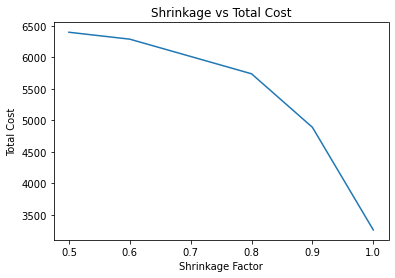

In [16]:
import matplotlib.pyplot as plt

x = [0.5,0.6,0.8,0.9,1]
y = [shrinkage_simulation(s) for s in x]

plt.plot(x,y)
plt.title("Shrinkage vs Total Cost")
plt.xlabel("Shrinkage Factor")
plt.ylabel("Total Cost")
plt.show()

Berdasarkan visualisasi di atas semakin tinggi shrinkage factor maka total biaya yang dikeluarkan untuk mengirimkan produk menjadi lebih murah. Shrinkage factor 100% artinya tidak ada produk cacat setelah melewati gudang. Tingginya total biaya pengiriman akibat shrinkage factor yang rendah diakibatkan oleh kecenderungan pabrik yang mengirimkan produk secara langsung dari pabrik menuju retailer tanpa menggunakan gudang. Hal itu bisa dibuktikan melalui tabel biaya di bawah ini. Misalkan biaya pengiriman dari pabrik 1 ke retailer 1 secara langsung adalah sebesar **20 dolar per unit**. Jika menggunakan gudang 1 misalnya, maka biaya pengiriman akan menjadi **7 dolar per unit**. Namun dikarenakan terjadi shrinkage pada gudang, perusahaan lebih memilih tidak menggunakan gudang.

In [17]:
cost

,Plant 1,Plant 2,Plant 3,Warehouse 1,Warehouse 2,Retailer 1,Retailer 2
From/To,,,,,,,
Plant 1,NaN,5.0,3.0,5.0,5.0,20.0,20.0
Plant 2,9.0,NaN,9.0,1.0,1.0,8.0,15.0
Plant 3,0.4,8.0,NaN,1.0,0.5,10.0,12.0
Warehouse 1,NaN,NaN,NaN,NaN,1.2,2.0,12.0
Warehouse 2,NaN,NaN,NaN,0.8,NaN,2.0,12.0
Retailer 1,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Retailer 2,NaN,NaN,NaN,NaN,NaN,7.0,NaN
